In [49]:
import os
import math
from os import path
from datetime import datetime, timedelta, date
import pytz

import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Various datasets to visualize

option = 5

if option == 1:
    base_folder = "./retreat2020"
    sim_id = 29
    sim_tz = "US/Eastern"
if option == 2:
    base_folder = "./cmutest"
    sim_id = 32
    sim_tz = "US/Mountain"
if option == 3:
    base_folder = "./cmu"
    sim_id = 34
    sim_tz = "US/Mountain"
if option == 4:
    base_folder = "./fgcu"
    sim_id = 33
    sim_tz = "US/Eastern"
if option == 5:
    base_folder = "./csw1"
    sim_id = 36
    sim_tz = "US/Eastern" 

In [40]:
# Some config

# Coded outcomes:
# 0 = no infection
# 1 = index case
# 2 = transmission
color_dict = {0: "skyblue", 1: "crimson", 2: "orange"}

data_folder = path.join(base_folder, "data")
output_folder = path.join(base_folder, "output", "epi_plots")
if not path.exists(output_folder):
    os.makedirs(output_folder)
    
frame_format = "png"
create_movie = True
movie_fps = 2

# In seconds
time_delta = 15 * 60

exclude_time0 = timezone.localize(datetime.strptime('Nov 16 2020 9:00PM', '%b %d %Y %I:%M%p'))
exclude_time1 = timezone.localize(datetime.strptime('Nov 17 2020 7:00AM', '%b %d %Y %I:%M%p'))

# https://howchoo.com/g/ywi5m2vkodk/working-with-datetime-objects-and-timezones-in-python
# https://itnext.io/working-with-timezone-and-python-using-pytz-library-4931e61e5152
timezone = pytz.timezone(sim_tz)

In [41]:
# Load participants and histories

all_users = pd.read_csv(path.join(data_folder, "participants.csv")) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"))

users = all_users[all_users["sim_id"] == sim_id]
events = all_events[all_events["sim_id"] == sim_id]

events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int)

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()
        
user_index = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    idx += 1

# These should return the same value
print(len(users))
print(len(idTop2p))    
print(len(p2pToId))
print(len(user_index))

99
99
88
99


In [42]:
min_time = min(events['time'])
max_time = max(events['time'])

first_date = datetime.fromtimestamp(min_time, tz=timezone)
last_date = datetime.fromtimestamp(max_time, tz=timezone)

print("First event:", first_date)
print("Last event :", last_date)
print(first_date.tzinfo)

First event: 2020-11-16 07:58:47-05:00
Last event : 2020-11-17 19:47:41-05:00
US/Eastern


skipping 2020-11-16 21:13:47-05:00
skipping 2020-11-16 21:28:47-05:00
skipping 2020-11-16 21:43:47-05:00
skipping 2020-11-16 21:58:47-05:00
skipping 2020-11-16 22:13:47-05:00
skipping 2020-11-16 22:28:47-05:00
skipping 2020-11-16 22:43:47-05:00
skipping 2020-11-16 22:58:47-05:00
skipping 2020-11-16 23:13:47-05:00
skipping 2020-11-16 23:28:47-05:00
skipping 2020-11-16 23:43:47-05:00
skipping 2020-11-16 23:58:47-05:00
skipping 2020-11-17 00:13:47-05:00
skipping 2020-11-17 00:28:47-05:00
skipping 2020-11-17 00:43:47-05:00
skipping 2020-11-17 00:58:47-05:00
skipping 2020-11-17 01:13:47-05:00
skipping 2020-11-17 01:28:47-05:00
skipping 2020-11-17 01:43:47-05:00
skipping 2020-11-17 01:58:47-05:00
skipping 2020-11-17 02:13:47-05:00
skipping 2020-11-17 02:28:47-05:00
skipping 2020-11-17 02:43:47-05:00
skipping 2020-11-17 02:58:47-05:00
skipping 2020-11-17 03:13:47-05:00
skipping 2020-11-17 03:28:47-05:00
skipping 2020-11-17 03:43:47-05:00
skipping 2020-11-17 03:58:47-05:00
skipping 2020-11-17 

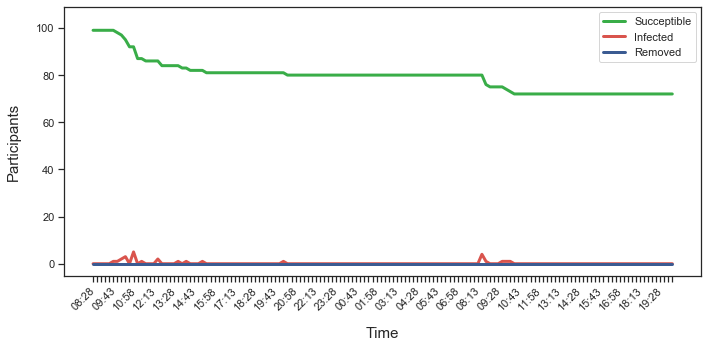

<Figure size 432x288 with 0 Axes>

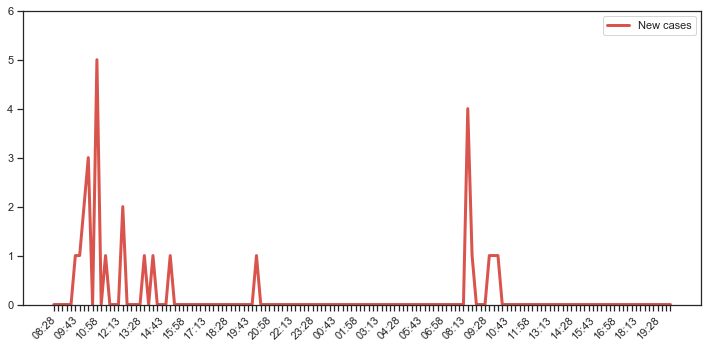

<Figure size 432x288 with 0 Axes>

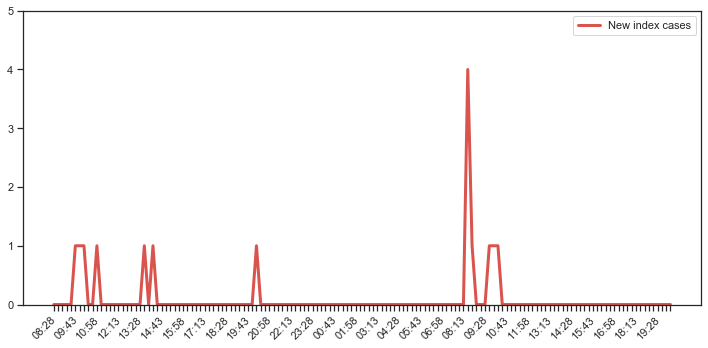

<Figure size 432x288 with 0 Axes>

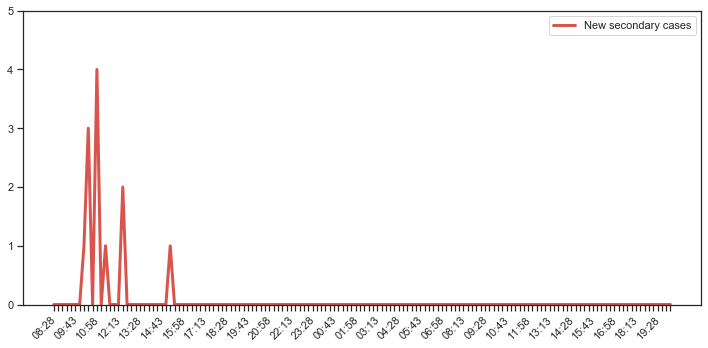

<Figure size 432x288 with 0 Axes>

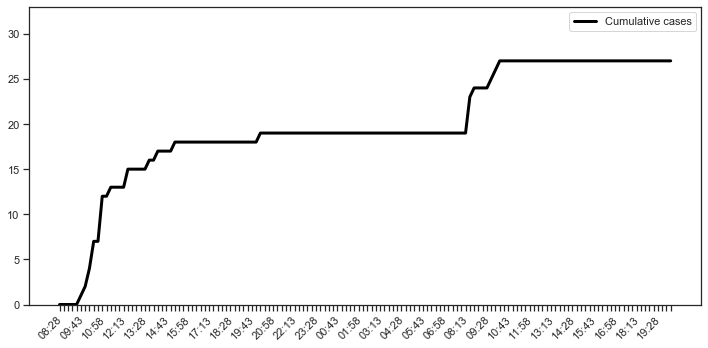

<Figure size 432x288 with 0 Axes>

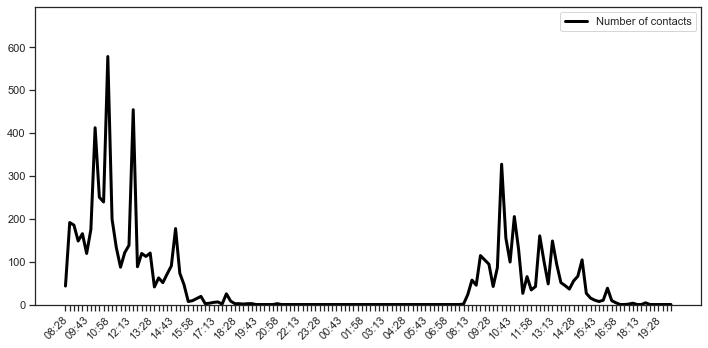

<Figure size 432x288 with 0 Axes>

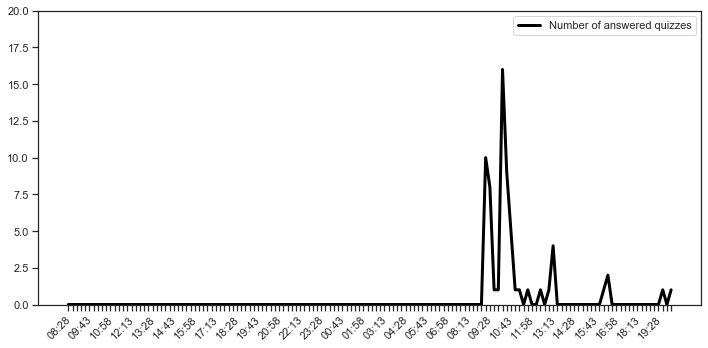

In [77]:
sns.set()
sns.set_style("ticks")

S = []
I = []
I0 = []
I2 = []
R = []
C = []
NC = []
NQ = []
index = []
tlabels = []
tlabels_all = []

ntot = len(users)
ncum = 0
t = min_time
idx = 0
img_array = []
label_spacing = 5
while t <= max_time:
    t0 = t
    t += time_delta
    td = datetime.fromtimestamp(t, tz=timezone)    
    frame += 1
    
    nrem = 0
    ninf = 0
    nindex = 0
    ntrans = 0  
    ncont = 0
    nquiz = 0
    
    if not (exclude_time0 <= td and td <= exclude_time1):
        condition = (t0 < events['time']) & (events['time'] <= t)    
        tevents = events[condition]        
        infections = tevents[tevents['type'] == "infection"]
        quizzes = tevents[tevents['type'] == "quiz"]
        outcomes = tevents[tevents['type'] == "outcomes"]
    
        recovered = outcomes[outcomes["out"] == "RECOVERED"]
        dead = outcomes[outcomes["out"] == "DEAD"]
        escaped = outcomes[outcomes["out"] == "ESCAPED"]
    
        nrem = len(recovered) + len(escaped) + len(dead)    

        ninf = len(infections)
        infMap = pd.Series(infections.inf.values, index=infections.id).to_dict()
        nindex = 0
        ntrans = 0    
        for kid in infMap:
            src = infMap[kid]
            if "CASE0" in src:
                nindex += 1
            if "PEER" in src:
                ntrans += 1
        
        ccondition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
        cevents = events[ccondition] 
        contacts = cevents[cevents['type'] == "contact"]     
        ncont = len(contacts)
    
        nquiz = len(quizzes)
        
    else:
        print("skipping", td)        
        
    S += [ntot - ncum]
    ncum += ninf
    
    I += [ninf]
    I0 += [nindex]
    I2 += [ntrans]    
    R += [nrem]
    C += [ncum]
    NC += [ncont]
    NQ += [nquiz]    
    
    index += [frame]
    if frame % label_spacing == 0:        
        tlabels += [td.strftime('%H:%M')]
    else:        
        tlabels += [""]
    tlabels_all += [td.strftime('%H:%M')]        

df = pd.DataFrame({"Time": tlabels_all,                    
                   "Susceptible": S, "Infected": I, "Removed": R, "Cumulative cases": C, 
                   "Index cases": I0, "Secondary cases": I2, 
                   "Number of contacts": NC, "Number of answered quizzes": NQ})
df.to_excel(os.path.join(output_folder, "epi-data.xlsx"), index=False)

# print(S)
# print(I)
# print(R)
# print(C)
# print(index)
# print(tlabels)

# Combined SIR curves
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([-5, ntot + 10])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
ax.plot(index, S, label="Succeptible", color=sns.xkcd_rgb["medium green"], lw=3)
ax.plot(index, I, label="Infected", color=sns.xkcd_rgb["pale red"], lw=3)
ax.plot(index, R, label="Removed", color=sns.xkcd_rgb["denim blue"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "epi-curves.pdf"))

# New cases plot (index and secondary)
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I) * 1.2)])
ax.plot(index, I, label="New cases", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "new-cases-curve.pdf"))

# Index cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I0) * 1.2)])
ax.plot(index, I0, label="New index cases", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "new-index_cases-curve.pdf"))

# Index cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I2) * 1.2)])
ax.plot(index, I2, label="New secondary cases", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "new-secondary_cases-curve.pdf"))

# Cumulative cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(C) * 1.2)])
ax.plot(index, C, label="Cumulative cases", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "cumulative-curve.pdf"))

# Number of contacts plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(NC) * 1.2)])
ax.plot(index, NC, label="Number of contacts", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "number-contacts-curve.pdf"))

# Number of answered quizzes
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(NQ) * 1.2)])
ax.plot(index, NQ, label="Number of answered quizzes", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "number-answered-quizzes-curve.pdf"))

In [ ]:
# Plot epi curves

# Styling with seaborn:
# https://seaborn.pydata.org/tutorial/aesthetics.html

sns.set()
sns.set_style("ticks")

S = []
I = []
R = []
C = []
time = []
tlabels = []

td = start_sim
ninf0 = 0
t = 0
while td <= stop_sim:
    _, _, _, ninf, nrem = construct_network(start_sim, td, ntot)

    if infer_new_cases_from_inf:
        # New cases are inferred from the infection time forward
        n = ninf
    else:
        # New cases are inferred from the removal time backwards
        n = nrem    
    
    dinf = n - ninf0
    ninf0 = n
    
    S += [ntot - n]
    
    I += [dinf]
    R += [nrem]
    C += [n]    
    
    time += [t]
    tlabels += [td.strftime('%H:%M')]
    td += viz_delta
    t += 1

if infer_new_cases_from_inf:
    d = int(asympt/vstep)
    S = [ntot] * d + S[0:len(S) - d]
    I = [0] * d + I[0:len(I) - d]
    C = [0] * d + C[0:len(C) - d]
else:    
    d = int(sympt/vstep)
    S = S[d:len(S)] + [S[len(S) - 1]] * d
    I = I[d:len(I)] + [0] * d
    C = C[d:len(C)] + [C[len(C) - 1]] * d

print(S)
print(I)
print(R)
print(C)

# Combined SIR curves
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([-5, ntot + 10])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
ax.plot(time, S, label="Succeptible", color=sns.xkcd_rgb["medium green"], lw=3)
ax.plot(time, I, label="Infected", color=sns.xkcd_rgb["pale red"], lw=3)
ax.plot(time, R, label="Removed", color=sns.xkcd_rgb["denim blue"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "epi-curves.pdf"))

# New cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I) * 1.2)])
ax.plot(time, I, label="New cases", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "new-cases-curve.pdf"))

# Cumulative cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(C) * 1.2)])
ax.plot(time, C, label="Cumulative cases", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "cumulative-curve.pdf"))


In [44]:
# R effective over time
td0 = start_sim
viz_delta2 = timedelta(minutes=vstep/2)
td = td0 + viz_delta
ninf0 = 0
t = 0
r_mean_values = []
r_std_values = []
tlabels = []
while td <= stop_sim:
    network, _, _, _, _ = construct_network(td0, td, ntot)
    
    inf_counts = {}
    for edge in network:
        n0 = edge["a"]
        if n0 not in ["unk", "zero", "src"]:
            if n0 in inf_counts:
                inf_counts[n0] = inf_counts[n0] + 1
            else:
                inf_counts[n0] = 1

    r_values = []
    for node in inf_counts:
        r_values += [inf_counts[node]]

    if r_values:
        r_mean = np.mean(r_values)
        r_std = np.std(r_values)
        r_mean_values += [r_mean]
        r_std_values += [r_std]
    else:
        r_mean_values += [0]
        r_std_values += [0]
    
    td0 = td - 2 * viz_delta
    tlabels += [td.strftime('%H:%M')]    
    td += viz_delta2
    
# Shifting forward because the calculation above is done at the time of infection    
d = int(2*asympt/vstep)
r_mean_values = [0] * d + r_mean_values[0:len(r_mean_values) - d]
r_std_values = [0] * d + r_std_values[0:len(r_std_values) - d]
    
mu = np.array(r_mean_values)
sigma = np.array(r_std_values)
time = np.arange(len(sigma))
    
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, mu, lw=2, label='R', color='blue')
ax.fill_between(time, mu+sigma, mu-sigma, facecolor='blue', alpha=0.5)

time2 = time[0::2]
tlabels2 = tlabels[0::2]
plt.xticks(time2, tlabels2, rotation=45, horizontalalignment="right")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "r-time-curve.pdf"))

NameError: name 'start_sim' is not defined

In [ ]:
# Plot distribution of R averaged over the entire simulation

network, _, _, _, _ = construct_network(start_sim, last_date + viz_delta, ntot, log = False)

inf_counts = {}
for edge in network:
    n0 = edge["a"]
    if n0 not in ["unk", "zero", "src"]:
        if n0 in inf_counts:
            inf_counts[n0] = inf_counts[n0] + 1
        else:
            inf_counts[n0] = 1

r_values = []
for node in inf_counts:
    r_values += [inf_counts[node]]
print(r_values)

r_mean = np.mean(r_values)
r_std = np.std(r_values)

print(r_mean, r_std)

counts, bins = np.histogram(r_values)
plt.ylabel("Counts", labelpad=15, fontsize=15)
plt.xlabel("R - mean = " + str(round(r_mean, 2)), labelpad=15, fontsize=15)
plt.hist(bins[:-1], bins, weights=counts)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "r-mean-histogram.pdf"))


In [ ]:
# Save case data and parameters for analysis in R

rows = []

td = start_sim
ninf0 = 0
t = 0
while td <= stop_sim:
    _, _, _, ninf, nrem = construct_network(start_sim, td, ntot)

    if infer_new_cases_from_inf:
        n = ninf
    else:
        n = nrem    
    
    dinf = n - ninf0
    ninf0 = n
    
    rows += [{"Count": dinf,
              "Time": t}]
    t += 1
    td += out_delta

case_data = pd.DataFrame(rows)
case_data.to_csv(os.path.join(output_folder, "case_counts.csv"), index = False)

param_data = pd.DataFrame([{"T":t, "dT":ostep, "N":ntot, "I0":case0_count}])
param_data.to_csv(os.path.join(output_folder, "input_params.csv"), index = False)